# Tutorial 3: Network Connections

In this tutorial, you'll learn:

- The projection architecture (Comm-Syn-Out)
- Connectivity patterns
- CUBA vs COBA output mechanisms
- Building excitatory-inhibitory networks
- Network simulation and analysis

In [1]:
import brainpy
import brainstate
import brainunit as u
import braintools
import matplotlib.pyplot as plt
import jax.numpy as jnp

## Part 1: Understanding Projections

BrainPy 3.0 uses a **three-stage projection architecture**:

```
Presynaptic    [Communication]  [Synapse]    [Output]     Postsynaptic
Spikes      →  Connectivity  →  Dynamics  →  Injection →  Neurons
               & Weights        Filtering     Mechanism
```

### Why This Design?

1. **Modularity**: Each stage is independent and swappable
2. **Clarity**: Clear separation of concerns
3. **Reusability**: Mix and match components
4. **Flexibility**: Easy to customize any stage

## Part 2: Simple Projection Example

In [8]:
# Set time step
brainstate.environ.set(dt=0.1 * u.ms)

# Create pre and post neurons
pre_neurons = brainpy.state.LIF(20, V_rest=-65.*u.mV, V_th=-50.*u.mV, V_reset=-65.*u.mV, tau=10.*u.ms)
post_neurons = brainpy.state.LIF(10, V_rest=-65.*u.mV, V_th=-50.*u.mV, V_reset=-65.*u.mV, tau=10.*u.ms)

# Create projection with all three stages
projection = brainpy.state.AlignPostProj(
    # Stage 1: Communication (connectivity + weights)
    comm=brainstate.nn.EventFixedProb(
        20, 
        10, 
        0.3,              # 30% connection probability
        0.5*u.mS        # Synaptic weight
    ),
    
    # Stage 2: Synapse (temporal dynamics)
    syn=brainpy.state.Expon.desc(10, tau=5.*u.ms),
    
    # Stage 3: Output (how to affect post neurons)
    out=brainpy.state.CUBA.desc(),
    
    # Target neurons
    post=post_neurons
)

print(f"Created projection: {20} → {10} neurons")
print(f"Connectivity: {0.3*100:.0f}% probability")
print(f"Expected connections: ~{20*10*0.3:.0f} synapses")
print(f"Synapse type: Exponential (τ=5ms)")
print(f"Output mechanism: CUBA (current-based)")

Created projection: 20 → 10 neurons
Connectivity: 30% probability
Expected connections: ~60 synapses
Synapse type: Exponential (τ=5ms)
Output mechanism: CUBA (current-based)


## Part 3: Testing the Projection

In [9]:
# Initialize all states
brainstate.nn.init_all_states(pre_neurons)
brainstate.nn.init_all_states(post_neurons)

# Simulate one step
# 1. Activate pre neurons with strong input
pre_neurons(5.0 * u.nA)

# 2. Get spikes from pre neurons
pre_spikes = pre_neurons.get_spike()
print(f"Pre spikes: {u.math.sum(pre_spikes != 0)} neurons fired")

# 3. Propagate through projection
projection(pre_spikes)

# 4. Check synaptic variable
print(f"Synaptic conductance (g): {projection.syn.g.value[:5]}")

# 5. Update post neurons (they receive synaptic input)
post_neurons(0. * u.nA)
post_spikes = post_neurons.get_spike()
print(f"Post spikes: {u.math.sum(post_spikes != 0)} neurons fired")

Pre spikes: 20 neurons fired
Synaptic conductance (g): ArrayImpl([0., 0., 0., 0., 0.], dtype=float32) * msiemens
Post spikes: 10 neurons fired


## Part 4: CUBA vs COBA Output

Two ways synapses can affect postsynaptic neurons:

### CUBA (Current-Based)
$$I_{syn} = g$$

- Simple: synaptic conductance directly becomes current
- Faster computation
- Less biologically realistic

### COBA (Conductance-Based)
$$I_{syn} = g \cdot (V - E_{rev})$$

- Realistic: current depends on driving force
- Voltage-dependent
- More biologically accurate

In [12]:
# Create neurons
neurons_cuba = brainpy.state.LIF(5, V_rest=-65.*u.mV, V_th=-50.*u.mV, tau=10.*u.ms)
neurons_coba = brainpy.state.LIF(5, V_rest=-65.*u.mV, V_th=-50.*u.mV, tau=10.*u.ms)
pre = brainpy.state.LIF(10, V_rest=-65.*u.mV, V_th=-50.*u.mV, tau=10.*u.ms)

# CUBA projection
proj_cuba = brainpy.state.AlignPostProj(
    comm=brainstate.nn.EventFixedProb(10, 5, 0.5, 1.0*u.mS),
    syn=brainpy.state.Expon.desc(5, tau=5.*u.ms),
    out=brainpy.state.CUBA.desc(),  # Current-based
    post=neurons_cuba
)

# COBA projection (excitatory reversal potential at 0 mV)
proj_coba = brainpy.state.AlignPostProj(
    comm=brainstate.nn.EventFixedProb(10, 5, 0.5, 1.0*u.mS),
    syn=brainpy.state.Expon.desc(5, tau=5.*u.ms),
    out=brainpy.state.COBA.desc(E=0.*u.mV),  # Conductance-based
    post=neurons_coba
)

print("CUBA: I_syn = g")
print("COBA: I_syn = g * (V - E_rev)")
print("\nWith V=-65mV and E=0mV:")
print("COBA current will be ~65mV larger (more driving force)")

CUBA: I_syn = g
COBA: I_syn = g * (V - E_rev)

With V=-65mV and E=0mV:
COBA current will be ~65mV larger (more driving force)


In [13]:
# Compare CUBA vs COBA
brainstate.nn.init_all_states(pre)
brainstate.nn.init_all_states(neurons_cuba)
brainstate.nn.init_all_states(neurons_coba)

duration = 100. * u.ms
dt = brainstate.environ.get_dt()
times = u.math.arange(0.*u.ms, duration, dt)

V_cuba_hist = []
V_coba_hist = []

for t in times:
    # Strong input to pre neurons
    pre(3.0 * u.nA)
    spikes = pre.get_spike()
    
    # Propagate through both projections
    proj_cuba(spikes)
    proj_coba(spikes)
    
    # Update post neurons
    neurons_cuba(0. * u.nA)
    neurons_coba(0. * u.nA)
    
    # Record voltages
    V_cuba_hist.append(neurons_cuba.V.value[0])
    V_coba_hist.append(neurons_coba.V.value[0])

V_cuba_hist = u.math.asarray(V_cuba_hist)
V_coba_hist = u.math.asarray(V_coba_hist)

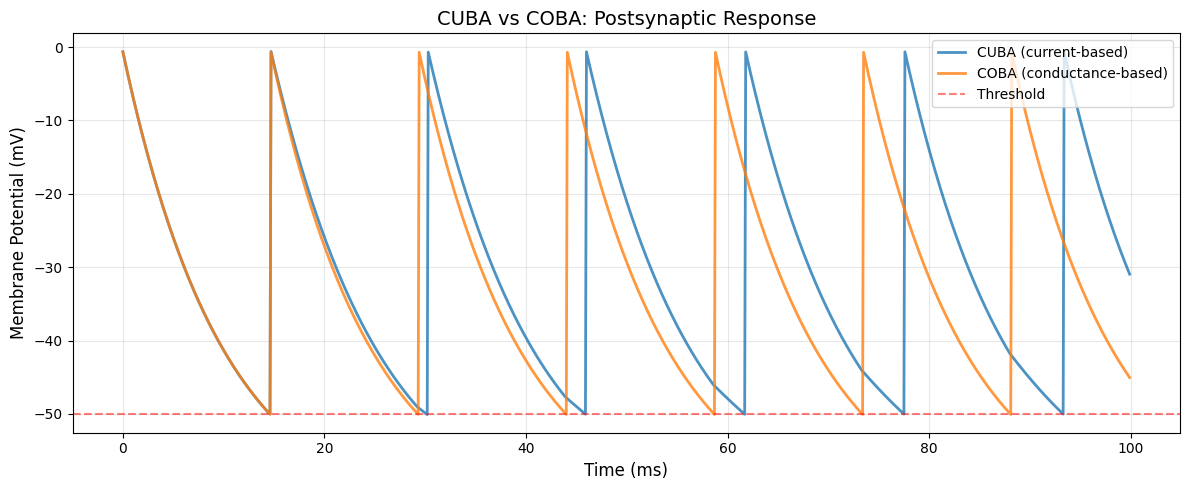

Observation: COBA produces stronger depolarization due to larger driving force


In [14]:
# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(times.to_decimal(u.ms), V_cuba_hist.to_decimal(u.mV), 
         linewidth=2, label='CUBA (current-based)', alpha=0.8)
plt.plot(times.to_decimal(u.ms), V_coba_hist.to_decimal(u.mV), 
         linewidth=2, label='COBA (conductance-based)', alpha=0.8)
plt.axhline(y=-50, color='r', linestyle='--', alpha=0.5, label='Threshold')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Membrane Potential (mV)', fontsize=12)
plt.title('CUBA vs COBA: Postsynaptic Response', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observation: COBA produces stronger depolarization due to larger driving force")

## Part 5: Building an Excitatory-Inhibitory Network

Let's build a classic E-I balanced network with:
- 80% excitatory neurons
- 20% inhibitory neurons
- All-to-all connectivity patterns

In [22]:
class EINetwork(brainstate.nn.Module):
    def __init__(self, n_exc=80, n_inh=20, prob=0.1):
        super().__init__()
        self.n_exc = n_exc
        self.n_inh = n_inh
        
        # Create neuron populations
        self.E = brainpy.state.LIF(
            n_exc, 
            V_rest=-65.*u.mV, 
            V_th=-50.*u.mV, 
            V_reset=-65.*u.mV,
            tau=10.*u.ms,
            V_initializer=braintools.init.Normal(-65., 5., unit=u.mV)
        )
        
        self.I = brainpy.state.LIF(
            n_inh,
            V_rest=-65.*u.mV,
            V_th=-50.*u.mV,
            V_reset=-65.*u.mV,
            tau=10.*u.ms,
            V_initializer=braintools.init.Normal(-65., 5., unit=u.mV)
        )
        
        # Excitatory projections (fast, AMPA-like)
        self.E2E = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_exc, n_exc, prob, 0.3*u.mS),
            syn=brainpy.state.Expon.desc(n_exc, tau=2.*u.ms),  # Fast excitation
            out=brainpy.state.CUBA.desc(),
            post=self.E
        )
        
        self.E2I = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_exc, n_inh, prob, 0.3*u.mS),
            syn=brainpy.state.Expon.desc(n_inh, tau=2.*u.ms),
            out=brainpy.state.CUBA.desc(),
            post=self.I
        )
        
        # Inhibitory projections (slower, GABAa-like)
        self.I2E = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_inh, n_exc, prob, -2.0*u.mS),
            syn=brainpy.state.Expon.desc(n_exc, tau=10.*u.ms),  # Slower inhibition
            out=brainpy.state.CUBA.desc(),
            post=self.E
        )
        
        self.I2I = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_inh, n_inh, prob, -2.0*u.mS),
            syn=brainpy.state.Expon.desc(n_inh, tau=10.*u.ms),
            out=brainpy.state.CUBA.desc(),
            post=self.I
        )
    
    def update(self, inp_e, inp_i):
        """Update network for one time step.
        
        Key: Get spikes BEFORE updating neurons!
        """
        # Get spikes from previous timestep
        spk_e = self.E.get_spike()
        spk_i = self.I.get_spike()
        
        # Update projections (uses previous spikes)
        self.E2E(spk_e)
        self.E2I(spk_e)
        self.I2E(spk_i)
        self.I2I(spk_i)
        
        # Update neurons (receives synaptic input)
        self.E(inp_e)
        self.I(inp_i)
        
        return spk_e, spk_i

# Create network
net = EINetwork(n_exc=80, n_inh=20, prob=0.1)
print(f"Created E-I network:")
print(f"  - {net.n_exc} excitatory neurons")
print(f"  - {net.n_inh} inhibitory neurons")
print(f"  - {net.n_exc + net.n_inh} total neurons")
print(f"  - 10% connectivity")
print(f"  - 4 projection types (E2E, E2I, I2E, I2I)")

Created E-I network:
  - 80 excitatory neurons
  - 20 inhibitory neurons
  - 100 total neurons
  - 10% connectivity
  - 4 projection types (E2E, E2I, I2E, I2I)


## Part 6: Simulate the Network

In [27]:
# Initialize all states
brainstate.nn.init_all_states(net)

# Simulation parameters
duration = 500. * u.ms
dt = brainstate.environ.get_dt()
times = u.math.arange(0.*u.ms, duration, dt)

# External input currents
I_ext_e = 20 * u.mA  # To excitatory neurons
I_ext_i = 16 * u.mA  # To inhibitory neurons

# Define simulation step
def sim_step(t):
    return net.update(I_ext_e, I_ext_i)

print("Running simulation...")
print(f"Duration: {duration}")
print(f"Time step: {dt}")
print(f"Steps: {len(times)}")

# Run simulation with progress bar
spikes = brainstate.transform.for_loop(
    sim_step, 
    times,
    pbar=brainstate.transform.ProgressBar(10)
)

spk_e, spk_i = spikes
print("\nSimulation complete!")

Running simulation...
Duration: 500.0 * msecond
Time step: 0.1 * msecond
Steps: 5000


  0%|          | 0/5000 [00:00<?, ?it/s]


Simulation complete!


## Part 7: Analyze Network Activity

In [28]:
# Calculate statistics
n_spikes_e = int(u.math.sum(spk_e != 0))
n_spikes_i = int(u.math.sum(spk_i != 0))
n_spikes_total = n_spikes_e + n_spikes_i

# Firing rates
duration_s = duration.to_decimal(u.second)
rate_e = n_spikes_e / (net.n_exc * duration_s)
rate_i = n_spikes_i / (net.n_inh * duration_s)
rate_total = n_spikes_total / ((net.n_exc + net.n_inh) * duration_s)

print("Network Statistics:")
print("="*50)
print(f"Total spikes: {n_spikes_total}")
print(f"  - Excitatory: {n_spikes_e} ({n_spikes_e/n_spikes_total*100:.1f}%)")
print(f"  - Inhibitory: {n_spikes_i} ({n_spikes_i/n_spikes_total*100:.1f}%)")
print(f"\nFiring Rates:")
print(f"  - Excitatory population: {rate_e:.2f} Hz")
print(f"  - Inhibitory population: {rate_i:.2f} Hz")
print(f"  - Overall network: {rate_total:.2f} Hz")

Network Statistics:
Total spikes: 2863
  - Excitatory: 2606 (91.0%)
  - Inhibitory: 257 (9.0%)

Firing Rates:
  - Excitatory population: 65.15 Hz
  - Inhibitory population: 25.70 Hz
  - Overall network: 57.26 Hz


## Part 8: Visualize Network Activity

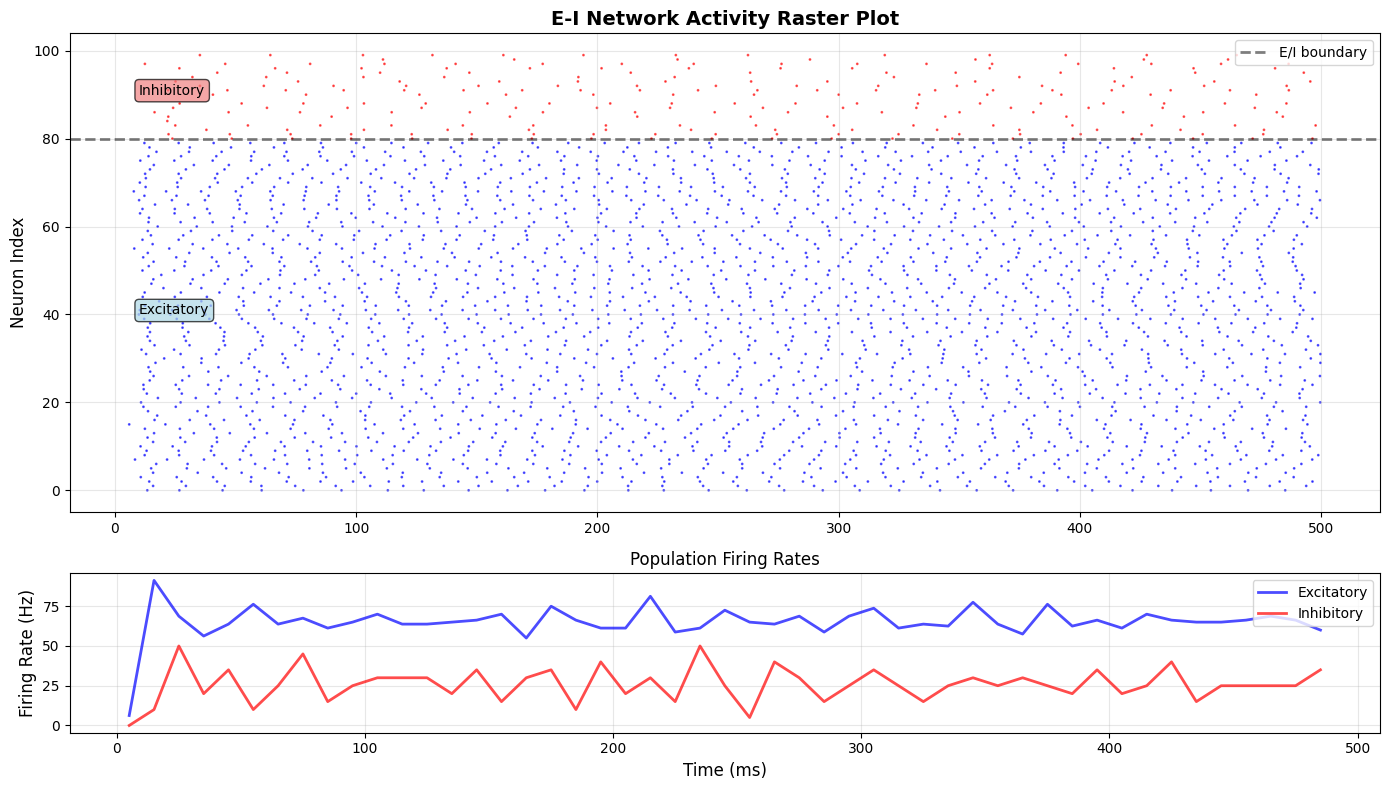

In [29]:
# Combine E and I spikes
all_spikes = u.math.concatenate([spk_e, spk_i], axis=1)

# Find spike times and neuron indices
t_idx, n_idx = u.math.where(all_spikes != 0)
spike_times = times[t_idx].to_decimal(u.ms)

# Create raster plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8), 
                        gridspec_kw={'height_ratios': [3, 1]})

# Raster plot
colors = ['blue' if i < net.n_exc else 'red' for i in n_idx]
axes[0].scatter(spike_times, n_idx, s=1, c=colors, alpha=0.6)
axes[0].axhline(y=net.n_exc, color='black', linestyle='--', 
                alpha=0.5, linewidth=2, label='E/I boundary')
axes[0].set_ylabel('Neuron Index', fontsize=12)
axes[0].set_title('E-I Network Activity Raster Plot', fontsize=14, fontweight='bold')
axes[0].text(10, net.n_exc/2, 'Excitatory', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
axes[0].text(10, net.n_exc + net.n_inh/2, 'Inhibitory', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Population firing rate over time
bin_size = 10 * u.ms
bins = u.math.arange(0.*u.ms, duration, bin_size)
bins_decimal = bins.to_decimal(u.ms)

# Calculate rates for E and I
t_idx_e, _ = u.math.where(spk_e != 0)
t_idx_i, _ = u.math.where(spk_i != 0)

hist_e, _ = u.math.histogram(times[t_idx_e].to_decimal(u.ms), bins=bins_decimal)
hist_i, _ = u.math.histogram(times[t_idx_i].to_decimal(u.ms), bins=bins_decimal)

rate_e = hist_e / (net.n_exc * bin_size.to_decimal(u.second))
rate_i = hist_i / (net.n_inh * bin_size.to_decimal(u.second))

bin_centers = bins[:-1] + bin_size/2
axes[1].plot(bin_centers.to_decimal(u.ms), rate_e, linewidth=2, 
            label='Excitatory', color='blue', alpha=0.7)
axes[1].plot(bin_centers.to_decimal(u.ms), rate_i, linewidth=2, 
            label='Inhibitory', color='red', alpha=0.7)
axes[1].set_xlabel('Time (ms)', fontsize=12)
axes[1].set_ylabel('Firing Rate (Hz)', fontsize=12)
axes[1].set_title('Population Firing Rates', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 9: Connectivity Patterns

Different connectivity strategies:

In [31]:
# Example: Different connectivity patterns

# 1. Fixed probability (what we used)
conn_fixed_prob = brainstate.nn.EventFixedProb(
    20, 10, 0.3, 0.5*u.mS
)

# 2. All-to-all (full connectivity)
# conn_all2all = brainstate.nn.EventFixedProb(
#     20, 10, prob=1.0, weight=0.5*u.mS
# )

# 3. One-to-one (for same-sized populations)
# conn_one2one = brainstate.nn.EventOne2One(
#     10, 10, weight=0.5*u.mS
# )

print("Connectivity patterns:")
print("1. FixedProb: Random connections with fixed probability")
print("2. All2All: Every neuron connects to every other")
print("3. One2One: Neuron i connects only to neuron i")
print("\nYou can also create custom connectivity!")

Connectivity patterns:
1. FixedProb: Random connections with fixed probability
2. All2All: Every neuron connects to every other
3. One2One: Neuron i connects only to neuron i

You can also create custom connectivity!


## Part 10: Network Variations

Experiment with different parameters:

In [32]:
# Try these experiments:

print("Experiments to try:")
print("\n1. Change E/I balance:")
print("   - Increase inhibitory weight → more synchrony")
print("   - Decrease inhibitory weight → more irregular")

print("\n2. Change connectivity:")
print("   - Higher prob → more correlated activity")
print("   - Lower prob → more independent neurons")

print("\n3. Change time constants:")
print("   - Faster inhibition → sharper oscillations")
print("   - Slower inhibition → smoother dynamics")

print("\n4. Change external input:")
print("   - Stronger input → higher firing rates")
print("   - Unbalanced input → population bias")

Experiments to try:

1. Change E/I balance:
   - Increase inhibitory weight → more synchrony
   - Decrease inhibitory weight → more irregular

2. Change connectivity:
   - Higher prob → more correlated activity
   - Lower prob → more independent neurons

3. Change time constants:
   - Faster inhibition → sharper oscillations
   - Slower inhibition → smoother dynamics

4. Change external input:
   - Stronger input → higher firing rates
   - Unbalanced input → population bias


## Summary

In this tutorial, you learned:

✅ **Projection Architecture**: Comm-Syn-Out three-stage design

✅ **Connectivity Patterns**: Fixed probability, all-to-all, one-to-one

✅ **Output Mechanisms**: CUBA (current-based) vs COBA (conductance-based)

✅ **E-I Networks**: Building balanced excitatory-inhibitory networks

✅ **Network Simulation**: Running and analyzing network dynamics

✅ **Visualization**: Raster plots and population firing rates

## Key Concepts

1. **Update Order**: Always get spikes BEFORE updating projections
2. **Modular Design**: Each projection component is independent
3. **E-I Balance**: Inhibition counteracts excitation for stable dynamics
4. **Time Constants**: Excitation fast (2ms), inhibition slow (10ms)

## Next Steps

- **Tutorial 4**: Learn about [Input and Output](04-input-output.ipynb)
- **Examples**: See [E-I networks in action](../../examples/gallery.rst)
- **Advanced**: Explore [oscillation mechanisms](../../examples/gallery.rst#oscillations-and-rhythms)

## Exercises

Try these on your own:

1. Create a network with 3 populations (E1, E2, I)
2. Implement distance-dependent connectivity
3. Add COBA synapses with different reversal potentials
4. Implement a feedforward network (no recurrence)
5. Analyze inter-spike intervals (ISI) distribution